# Quaternion Update

In [1]:
# load data
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *

# data loading
folder_path = '/Users/antongolles/Documents/uni/masters/myMasters/applied_machine_learning/inertial_navigation_transformer/data/data_from_RoNIN/train_dataset_1/'
params = {'Ntrain': 10_000, 'Nval': 100, 'seq_len': 10, 
          'input': ['synced/acce', 'synced/magnet', 'synced/gyro'], 
          'output': ['pose/tango_ori'], 
          'normalize': False}
X, y = load_split_data(folder_path, **params)

file_path = '../data/data_from_RoNIN/train_dataset_1/a000_1/data.hdf5'
data_dict = load_data(file_path, verbose=False)

# prepare data
## use only last ori as target
## and first ori as input as well as flatten the input
X = np.hstack( [ X.reshape(X.shape[0], -1), y[:,0,:] ] )
y = y[:,-1,:]

## train test split
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

## dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

## dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Loading file: /Users/antongolles/Documents/uni/masters/myMasters/applied_machine_learning/inertial_navigation_transformer/data/data_from_RoNIN/train_dataset_1/a017_1/data.hdf5
(808, 94) (808, 4) (202, 94) (202, 4)


## NN

In [6]:
# Set no. of layers in model
Nlayers = 8
# Set neurons per layer in model
hidden_size = 128
# Set learning rate
learning_rate = 0.0001
# Set loss function
criterion = nn.L1Loss()
# set n_epochs
num_epochs = 60


# set up a neural network with 3 inputs and 16 outputs
# the 3 inputs are the 3 components of the angular velocity
# the 16 outputs are the 16 elements of the 4x4 matrix Theta(w)


class Net(nn.Module):
    def __init__(self, input_size=13, output_size=16, hidden_size=16, num_layers=2):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.fc_input = nn.Linear(input_size, hidden_size)
        hidden_layers = []
        for i in range(self.num_layers):
            hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.hidden_layers = nn.ModuleList(hidden_layers)

        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #print(x)
        x = F.relu(self.fc_input(x))
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layers[i](x))
            
        x = self.fc_output(x)
        return x

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


net = Net(input_size=X_test.shape[1], output_size=4, hidden_size=hidden_size, num_layers=Nlayers)

# mount model to device
net.to(device)
# number of params
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Using device: cpu
Number of parameters: 144772


In [7]:
import time

# optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)


t_start = time.time()
for epoch in range(num_epochs):
    running_loss = 0.0
    n_minibatches = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n_minibatches += 1
    print('Epoch %d, loss: %.5f' % (epoch+1, running_loss/n_minibatches))

    # test
    with torch.no_grad():
        running_loss = 0.0
        n_minibatches = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            n_minibatches += 1
        print('Test loss: %.5f' % (running_loss/n_minibatches))

t_end = time.time()
print("Training time: ", t_end - t_start)

Epoch 1, loss: 0.50197
Test loss: 0.49331
Epoch 2, loss: 0.49143
Test loss: 0.48183
Epoch 3, loss: 0.47869
Test loss: 0.46647
Epoch 4, loss: 0.45985
Test loss: 0.44195
Epoch 5, loss: 0.43100
Test loss: 0.40413
Epoch 6, loss: 0.37846
Test loss: 0.32283
Epoch 7, loss: 0.26799
Test loss: 0.18974
Epoch 8, loss: 0.17704
Test loss: 0.14715
Epoch 9, loss: 0.12655
Test loss: 0.11572
Epoch 10, loss: 0.11471
Test loss: 0.11420
Epoch 11, loss: 0.10765
Test loss: 0.10792
Epoch 12, loss: 0.10384
Test loss: 0.10601
Epoch 13, loss: 0.10268
Test loss: 0.10435
Epoch 14, loss: 0.10111
Test loss: 0.10378
Epoch 15, loss: 0.10023
Test loss: 0.10337
Epoch 16, loss: 0.09945
Test loss: 0.10260
Epoch 17, loss: 0.09870
Test loss: 0.10178
Epoch 18, loss: 0.09798
Test loss: 0.10124
Epoch 19, loss: 0.09726
Test loss: 0.10058
Epoch 20, loss: 0.09658
Test loss: 0.10002
Epoch 21, loss: 0.09586
Test loss: 0.09955
Epoch 22, loss: 0.09499
Test loss: 0.09868
Epoch 23, loss: 0.09393
Test loss: 0.09760
Epoch 24, loss: 0.09

## Testing

q_pred (1000, 4) q_gt (1000, 4) x (1000,)
q_pred (50, 4) q_gt torch.Size([50, 4]) x (50,)


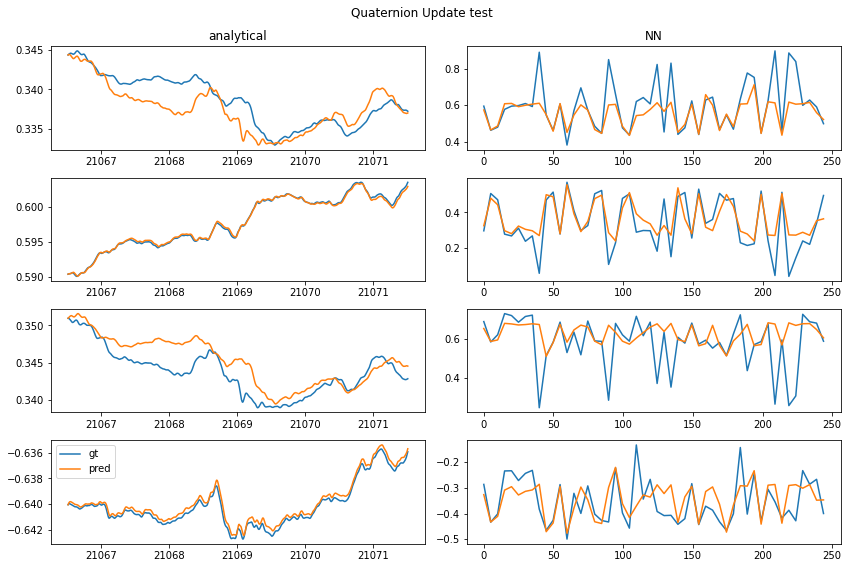

In [8]:
# Predict angles analytically
N = 1000
q_gt = data_dict['pose/tango_ori'][:N]
a = data_dict['synced/acce'][:N]
m = data_dict['synced/magnet'][:N]
w = data_dict['synced/gyro'][:N]
dt = data_dict['synced/time'][1] - data_dict['synced/time'][0]

q_pred_ana = np.zeros((N,4))
q_pred_ana[0] = q_gt[0]
factor= .0025                                # has been set arbitrarily
for i in range(1,N):
    q_pred_ana[i] = Theta(w[i]*factor, dt=dt)@q_pred_ana[i-1]


# plot
def plot_quat(q_gts, q_preds, xs, names = ['analytical', 'NN']):
    if type(q_preds) is not list:
        q_preds = [q_preds]
    if type(q_gts) is not list:
        q_gts = [q_gts]
    if type(xs) is not list:
        xs = [xs]
    
    fig, ax = plt.subplots(4,len(q_preds), figsize=(12, 4*len(q_preds)))
    ax = ax.reshape(4, -1).T
    idx = 0
    for q_pred, q_gt,x, name in zip(q_preds, q_gts,xs, names):
        print('q_pred', q_pred.shape, 'q_gt', q_gt.shape, 'x', x.shape)
        ax[idx, 0].plot(x, q_gt[:,0],)
        ax[idx, 0].plot(x, q_pred[:,0],)
        ax[idx, 1].plot(x, q_gt[:,1],)
        ax[idx, 1].plot(x, q_pred[:,1],)
        ax[idx, 2].plot(x, q_gt[:,2],)
        ax[idx, 2].plot(x, q_pred[:,2],)
        ax[idx, 3].plot(x, q_gt[:,3],label='gt')
        ax[idx, 3].plot(x, q_pred[:,3],label=f'pred')
        
        ax[idx, 0].set_title(name)
        idx += 1
    ax[0, 3].legend()
    fig.suptitle('Quaternion Update test')
    plt.tight_layout()


# testing NN

y_pred = []

with torch.no_grad():
    for i in range(X_test.shape[0]):
        if i > 0:
            X_test[i, -4:] = torch.tensor(y_pred[i-1])
        y_pred.append(net(X_test[i].to(device)).cpu().numpy())
y_pred = np.array(y_pred).squeeze()


up_to = 50
plot_quat([q_gt, y_test[:up_to]], 
          [q_pred_ana, y_pred[:up_to]], 
          [data_dict['synced/time'][:N], 
           np.linspace(0, N, len(y_test))[:up_to]], 
          names=['analytical', 'NN'])